Imports

In [1]:
__author__ = "Artur Fejklowicz"

# Sources:
# - https://medium.com/@ashins1997/text-classification-dfe370bf7044
# - https://www.kaggle.com/code/shahkan/text-classification-using-logistic-regression
# - https://www.kaggle.com/code/satishgunjal/multiclass-logistic-regression-using-sklearn
# - https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
# - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

import pandas as pd
import numpy as np
import os
import backoff
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from google.cloud import bigquery
from google.cloud import storage
import matplotlib.pyplot as plt
import nltk.stem.snowball
from sklearn.metrics import ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
#import seaborn as sns
import urllib.request
from pathlib import Path
import joblib
import pickle
from datetime import datetime


Support utils

In [2]:
data_path = Path("../../../../tmp/transak/")
data_path.mkdir(parents=True, exist_ok=True)
gs = storage.Client()
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
model_path = data_path / timestamp
model_path.mkdir(parents=True, exist_ok=True)
print(model_path)

@backoff.on_exception(backoff.expo, Exception, max_tries=5)
def save_to_gcs(python_object, blob_base_name:str = None, method:str = "pkl"):
    bucket_name = "af-finanzen-banks"
    blob_path = "models/lr"
    blob_name = f"{blob_path}/{timestamp}/{blob_base_name}.{method}"

    bucket = gs.bucket(bucket_name)
    blob_path = "models/lr"
    blob = bucket.blob(blob_name)
    file_path = data_path / timestamp / f"{blob_base_name}.{method}"
    if method == "pkl":
        with open(file_path, 'wb') as f:
            pickle.dump(python_object, f)
    elif method == "joblib":
        joblib.dump(python_object, file_path)
    else:
        raise Exception(f"No such save method: {method}")
    blob.upload_from_filename(file_path)
    print(f"Saved object to gs://{bucket_name}/{blob_name}")


..\..\..\..\tmp\transak\20241002234942


Retrive data from BigQuery

In [3]:
bq = bigquery.Client(project="af-finanzen")
query = ("""SELECT
  description
  -- , Konto
  , CASE 
      WHEN Konto in ("PK Auto", "PK Maja", "PK Rest", "SK Haushalt", "Top-Up") THEN "Others"
      ELSE Konto
    END as Konto
FROM banks.revolut_mapping_internal
""")
df = bq.query(query).to_dataframe()  # API request


## Data analysis

Basic

Number of classes: 5
Class names: ['Others' 'PK Artur' 'PK Leben' 'PK Reisen' 'SK Ferien']
Konto
Others        66
PK Artur      75
PK Leben     105
PK Reisen     70
SK Ferien     86
Name: Konto, dtype: int64


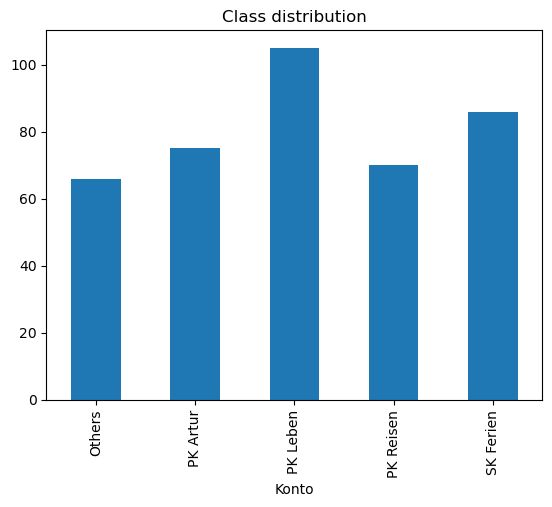

,description,Konto
0,Top-Up by *4356,Others
1,Refund from Amz*smithy By Dagmar N,Others
2,Splasz Studio Detailin,Others
3,Kraken Detailing,Others
4,Cash at Bienczycki Pl Targowy,Others
5,Wegrzyn & Wegrzyn S.j.,Others
6,Ley Autowaschpark W5,Others
7,Gama-M,Others
8,Fikołki,Others
9,Mini Melts Spolka Z O.o,Others


In [4]:
n_classes = df.Konto.nunique()
print(f"Number of classes: {n_classes}")

target_names = df.Konto.unique()
print(f"Class names: {target_names}")

print(df.groupby("Konto").Konto.count())
df.groupby("Konto").Konto.count().plot(kind="bar", ylim=0, )
plt.title("Class distribution")
plt.show()

# df["Konto"].astype("category").cat.codes.plot(kind="hist", color="green", width=0.8)
# plt.show()
# df.info()

pd.concat( [df.head(10), df.tail(10)] )

Histogram of words

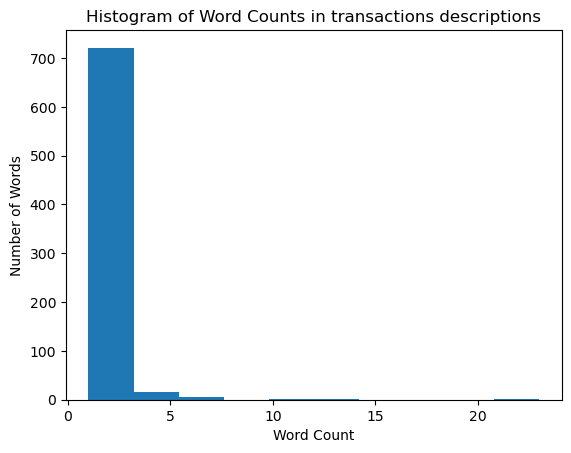

In [5]:
words = df.description.str.lower().str.split()
word_counts = words.explode().value_counts()
word_counts.plot(kind='hist')
plt.xlabel('Word Count')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Counts in transactions descriptions')
plt.show()

Because there is long tail I will show also visualization of percentiles. This shows, that over 85% of words occures only ones in whole corpus and less then 15% of words occures more then once. 

# This means that word embeddings would not be the optimal technic for feature eingineering here.

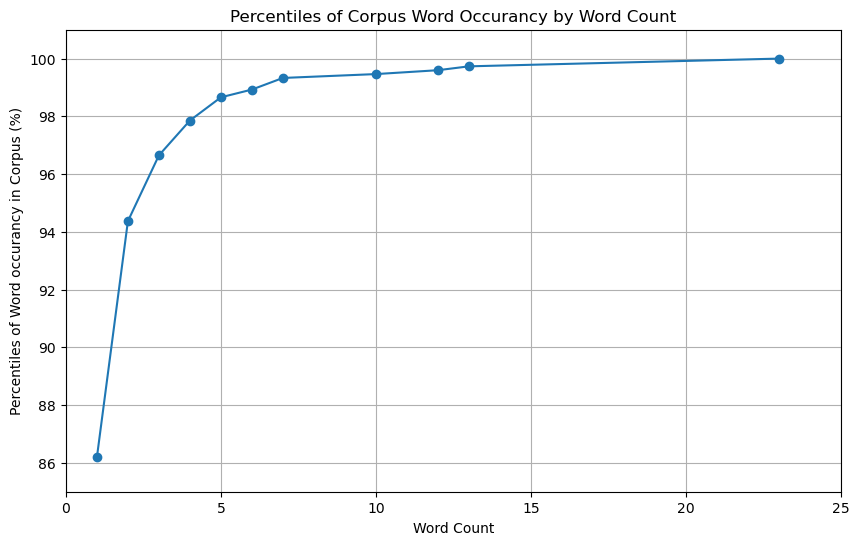

In [6]:
percentiles = word_counts.value_counts().sort_index().cumsum() / len(word_counts) * 100

# Plotting the percentiles
plt.figure(figsize=(10, 6))
plt.plot(percentiles.index, percentiles.values, marker='o')
plt.xlabel('Word Count')
plt.ylabel('Percentiles of Word occurancy in Corpus (%)')
plt.title('Percentiles of Corpus Word Occurancy by Word Count')
plt.grid(True)
plt.xlim(0, 25)
plt.ylim(85, 101)
plt.show()

Seaborn

In [7]:
# sns.set_theme()
# #df.groupby("Konto").Konto.count()
# sns.countplot(data=df, x="Konto")

Stopwords

In [8]:
stops_eng = set(stopwords.words('english'))
stops_ger = set(stopwords.words('german'))
stops_ita = set(stopwords.words('italian'))
stops_spa = set(stopwords.words('spanish'))
stops_fra = set(stopwords.words('french'))
link = "https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt"
lines=[]
responce = urllib.request.urlopen(link)
stops_pol = responce.read().decode().split(f"\n")

stops = list(stops_eng.union(stops_ger).union(stops_ita).union(stops_spa).union(stops_fra).union(stops_pol))


## Split Train-Test

In [9]:
X = df['description']
Y = df['Konto']

X_train_txt, X_test_txt, y_train_txt, y_test_txt = train_test_split(X, Y, test_size=0.3)

print(f"Trainig dataset: {X_train_txt.shape}, {y_train_txt.shape}")
print(f"Testing dataset: {X_test_txt.shape}, {y_test_txt.shape}")

Trainig dataset: (281,), (281,)
Testing dataset: (121,), (121,)


Save training and testing dataset

In [10]:
train_data = pd.concat([X_train_txt, y_train_txt], axis=1)
test_data = pd.concat([X_test_txt, y_test_txt], axis=1)

In [11]:
train_data.to_csv(data_path / timestamp / 'train_data.csv', index=False)
test_data.to_csv(data_path / timestamp / 'test_data.csv', index=False)
# 2 cells further split is loaded from diffferent location, because, it was representative split

In [12]:
test_data

,description,Konto
262,3 Brzeczkowice Manual (1),PK Reisen
230,Apo Am Fuerstenberg,PK Leben
85,Douglas,PK Artur
151,Zapiekanki Bienczyckie,PK Leben
324,La Casa Di Mamma Do,SK Ferien
...,...,...
24,NaszeUbrania.pl,Others
47,Google Pay Top-Up by *4356,Others
340,Azad Rezaul,SK Ferien
55,Refund from Amz*amazon.de,Others


Load data

In [13]:
train_data = pd.read_csv(data_path / 'train_data.csv')
test_data = pd.read_csv(data_path / 'test_data.csv')

In [14]:
train_data

,description,Konto
0,Google Pay Top-Up by *4356,Others
1,To Zentrale Bussgeldstelle,PK Artur
2,So! Coffee,PK Reisen
3,Smyk,Others
4,W Strone Centrum,Others
...,...,...
276,Gama-M,Others
277,Handel Detaliczny,PK Leben
278,Gust Gourmet Bar,SK Ferien
279,PTTK shelter on Hala Ornak,SK Ferien


In [15]:
X_train_txt = train_data.description
X_test_txt = test_data.description
y_train_txt = train_data.Konto
y_test_txt = test_data.Konto

In [16]:
X_train_txt


0      Google Pay Top-Up by *4356
1      To Zentrale Bussgeldstelle
2                      So! Coffee
3                            Smyk
4                W Strone Centrum
                  ...            
276                        Gama-M
277             Handel Detaliczny
278              Gust Gourmet Bar
279    PTTK shelter on Hala Ornak
280        Wegrzyn & Wegrzyn S.j.
Name: description, Length: 281, dtype: object

Encoding Labels

In [17]:
label_encoder = {'Others':0, 'PK Artur': 1, 'PK Leben': 2, 'PK Reisen': 3, 'SK Ferien': 4}
y_train = np.array([label_encoder[label] for label in y_train_txt])
y_test = np.array([label_encoder[label] for label in y_test_txt])

## Vecorization: Bag of Words

Training data

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()
X_train_counts_bow = count_vec.fit_transform(X_train_txt) # this will fit() the model
X_train_arr_bow = X_train_counts_bow.toarray()

X_train_arr_bow.shape
#count_vect.vocabulary_["asfinag"]
#len(count_vect.vocabulary_)
np.nonzero(X_train_arr_bow[0])
for i in [ 55, 535]:
    a = [k for (k, v) in count_vec.vocabulary_.items() if v == i]
    print(a)

['autogrill']
[]


Testing data

In [19]:
X_test_counts_bow = count_vec.transform(X_test_txt) # this will predict() the model - here was just transform instead fit_transform as for training
X_test_counts_bow.toarray().shape

(121, 515)

Model training

In [20]:
log_reg_bow = LogisticRegression(max_iter=1000)
log_reg_bow.fit(X_train_counts_bow, y_train)

LogisticRegression(max_iter=1000)

Model testing on training data

In [21]:
y_train_pred_bow = log_reg_bow.predict(X_train_counts_bow)
accuracy_score(y_train, y_train_pred_bow)

0.9857651245551602

Model testing on test data

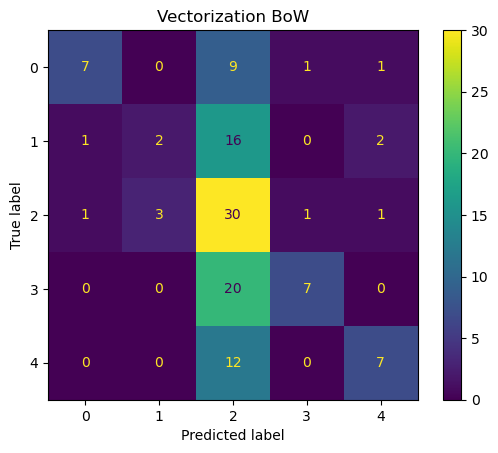

              precision    recall  f1-score   support

           0       0.78      0.39      0.52        18
           1       0.40      0.10      0.15        21
           2       0.34      0.83      0.49        36
           3       0.78      0.26      0.39        27
           4       0.64      0.37      0.47        19

    accuracy                           0.44       121
   macro avg       0.59      0.39      0.40       121
weighted avg       0.56      0.44      0.41       121



0.4380165289256198

In [22]:
y_test_pred_bow = log_reg_bow.predict(X_test_counts_bow)
test_pred_probas = {}
test_pred_probas["bow"] = log_reg_bow.predict_proba(X_test_counts_bow)

confusion_matrix_testing_bow = confusion_matrix(y_test, y_test_pred_bow)
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing_bow, display_labels=target_names)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing_bow)
disp.plot()
disp.ax_.set_title("Vectorization BoW")
plt.show()

from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_test_pred_bow)
print(classification_report)
c_report = {}
c_report["bow"] = classification_report

log_reg_bow_accuracy = accuracy_score(y_test, y_test_pred_bow)
log_reg_bow_accuracy


ROC

## Vectorization TF-IDF

Training data

In [23]:
tfidf_vec = TfidfVectorizer(
    #min_df=0.0001,
    #stop_words=stops, # without stops accuracy +0.01 precision +0.01 recall -0.01
    #max_features=1000,
    sublinear_tf=True, 
    #norm='l2', 
    ngram_range=(1, 2))
X_train_counts_tfidf = tfidf_vec.fit_transform(X_train_txt)
print(f"X_train_counts shape:\n{X_train_counts_tfidf.toarray().shape}")

X_train_counts shape:
(281, 874)


Lets see tfidf scores

In [24]:
X_array_tfidf = X_train_counts_tfidf.toarray()
np.nonzero(X_array_tfidf[0])

(array([ 26, 162, 163, 370, 372, 610, 611, 800, 801, 833, 834], dtype=int64),)

In [25]:
for i in [129, 593, 594]:
    print(X_array_tfidf[0][i])

0.0
0.0
0.0


Testing data

In [26]:
X_test_counts_tfidf = tfidf_vec.transform(X_test_txt)
X_test_counts_tfidf.toarray().shape

(121, 874)

Model training

In [27]:
log_reg_tfidf = LogisticRegression(max_iter=1000
                                   # , C=0.8
                                   # , penalty="l2"
                                   # , class_weight="balanced"
                                   )
log_reg_tfidf.fit(X_train_counts_tfidf, y_train)

LogisticRegression(max_iter=1000)

Testing on trainig data

In [28]:
y_train_pred_tfidf = log_reg_tfidf.predict(X_train_counts_tfidf)
accuracy_score(y_train, y_train_pred_tfidf)

0.9893238434163701

Model testing on test data

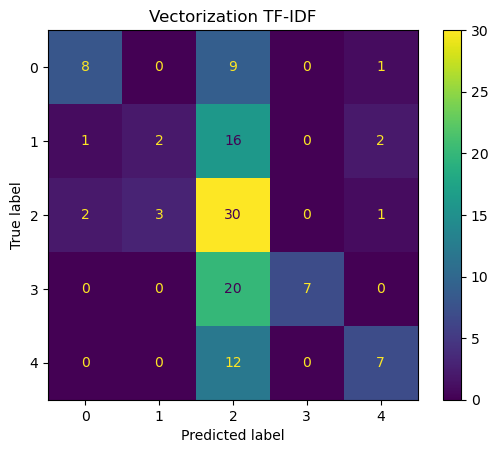

              precision    recall  f1-score   support

           0       0.73      0.44      0.55        18
           1       0.40      0.10      0.15        21
           2       0.34      0.83      0.49        36
           3       1.00      0.26      0.41        27
           4       0.64      0.37      0.47        19

    accuracy                           0.45       121
   macro avg       0.62      0.40      0.41       121
weighted avg       0.60      0.45      0.42       121



0.4462809917355372

In [29]:
y_test_pred_tfidf = log_reg_tfidf.predict(X_test_counts_tfidf)
test_pred_probas["tfidf"] = log_reg_tfidf.predict_proba(X_test_counts_tfidf)


confusion_matrix_testing_tfidf = confusion_matrix(y_test, y_test_pred_tfidf)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing_tfidf)
disp.plot()
disp.ax_.set_title("Vectorization TF-IDF")
plt.show()

from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_test_pred_tfidf)
print(classification_report)
c_report["tfidf"] = classification_report

log_reg_tfidf_accuracy = accuracy_score(y_test, y_test_pred_tfidf)
log_reg_tfidf_accuracy

## Vectorization: Word Embeddings - gensim

TODO:
- https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/multilingual/2
- https://fasttext.cc/docs/en/crawl-vectors.html

Vectorizer Preperation

In [30]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100') # acc 0.46
# word_vectors = api.load('glove-wiki-gigaword-50') # acc 0.38
# word_vectors = api.load('glove-wiki-gigaword-300') # acc 0.38
word_vectors.vector_size

100

In [31]:
len(word_vectors.key_to_index)

400000

Average of words in document and gize back vector filled with zeros when word can not be found in gensim embeddings

In [32]:
def document_vector(doc):
    doc = [word for word in doc if word in word_vectors.key_to_index]
    if not doc:
        return np.zeros(word_vectors.vector_size)
    return np.mean(word_vectors[doc], axis=0)

Vectorization

In [33]:
X_train_txt_split = X_train_txt.str.lower().str.split()
X_test_txt_split = X_test_txt.str.lower().str.split()

X_train_vec = np.array([document_vector(d) for d in X_train_txt_split])
X_test_vec = np.array([document_vector(d) for d in X_test_txt_split])
X_train_vec.shape

(281, 100)

Model training

In [34]:
log_reg_embeddings = LogisticRegression(max_iter=1000)
log_reg_embeddings.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

Model testing on training data

In [35]:
y_train_pred_embeddings = log_reg_embeddings.predict(X_train_vec)
accuracy_score(y_train, y_train_pred_embeddings)

0.8113879003558719

Model testing on testing data

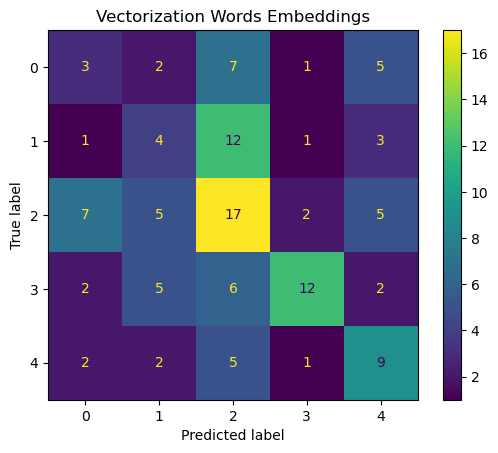

              precision    recall  f1-score   support

           0       0.20      0.17      0.18        18
           1       0.22      0.19      0.21        21
           2       0.36      0.47      0.41        36
           3       0.71      0.44      0.55        27
           4       0.38      0.47      0.42        19

    accuracy                           0.37       121
   macro avg       0.37      0.35      0.35       121
weighted avg       0.39      0.37      0.37       121



0.371900826446281

In [36]:
y_test_pred_embeddings = log_reg_embeddings.predict(X_test_vec)
test_pred_probas["embeddings"] = log_reg_embeddings.predict_proba(X_test_vec)

confusion_matrix_testing_embeddings = confusion_matrix(y_test, y_test_pred_embeddings)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing_embeddings)
disp.plot()
disp.ax_.set_title("Vectorization Words Embeddings")
plt.show()

from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_test_pred_embeddings)
print(classification_report)
c_report["embeddings"] = classification_report

log_reg_embeddings_accuracy = accuracy_score(y_test, y_test_pred_embeddings)
log_reg_embeddings_accuracy

## Metrics together BoW, TF-IDF, Embeddings

In [37]:
def draw_multiclass_roc(y_train_txt, y_test_txt, y_test_pred_proba, text=""):
    from sklearn.preprocessing import LabelBinarizer

    label_binarizer = LabelBinarizer().fit(y_train_txt)
    y_onehot_test = label_binarizer.transform(y_test_txt)
    y_onehot_test.shape  # (n_samples, n_classes)
    class_of_interest = "Others"
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]


    from sklearn.metrics import auc, roc_curve, RocCurveDisplay
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_test_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_test_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)
    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
    
    # the same as this, but we need previous calculations to draw all classes
    # from sklearn.metrics import roc_auc_score
    # macro_roc_auc_ovr = roc_auc_score(
    #     y_test,
    #     y_test_pred_proba_bow,
    #     multi_class="ovr",
    #     average="macro",
    # )
    # print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")


    from itertools import cycle
    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "hotpink", "lightgreen"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_test_pred_proba[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{text} Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
    )

In [38]:
for vec_kind in ["bow", "tfidf", "embeddings"]:
    print(f"Vectorizing kind: {vec_kind}")
    print(c_report[vec_kind])

Vectorizing kind: bow
              precision    recall  f1-score   support

           0       0.78      0.39      0.52        18
           1       0.40      0.10      0.15        21
           2       0.34      0.83      0.49        36
           3       0.78      0.26      0.39        27
           4       0.64      0.37      0.47        19

    accuracy                           0.44       121
   macro avg       0.59      0.39      0.40       121
weighted avg       0.56      0.44      0.41       121

Vectorizing kind: tfidf
              precision    recall  f1-score   support

           0       0.73      0.44      0.55        18
           1       0.40      0.10      0.15        21
           2       0.34      0.83      0.49        36
           3       1.00      0.26      0.41        27
           4       0.64      0.37      0.47        19

    accuracy                           0.45       121
   macro avg       0.62      0.40      0.41       121
weighted avg       0.60      0.

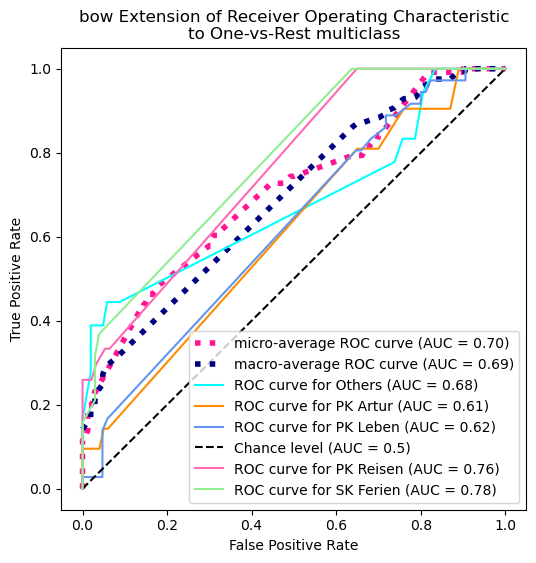

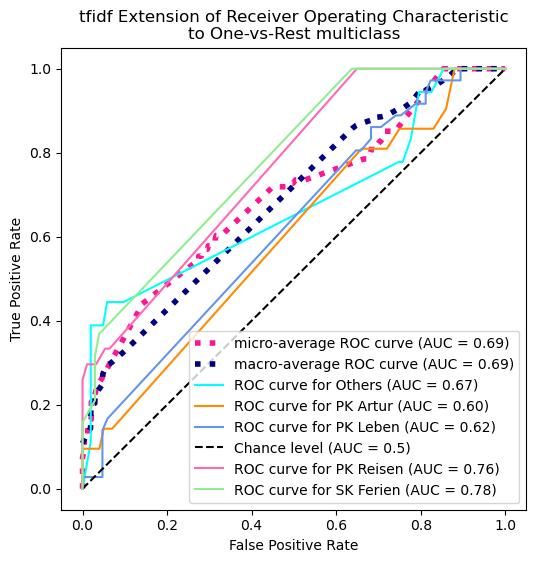

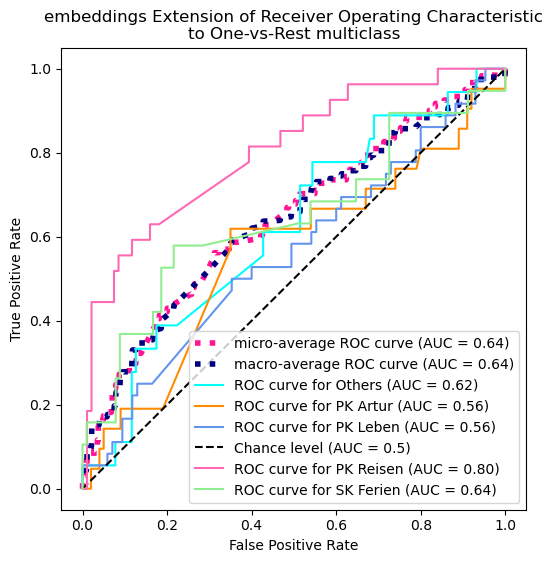

In [39]:
for vec_kind in ["bow", "tfidf", "embeddings"]:
    draw_multiclass_roc(y_train_txt, y_test_txt, test_pred_probas[vec_kind], vec_kind)


Save Game

In [40]:
save_to_gcs(count_vec, "vec_bow", "pkl")
save_to_gcs(tfidf_vec, "vec_tfidf", "pkl")

save_to_gcs(log_reg_bow, f'log_reg_bow_acc_{str(log_reg_bow_accuracy)[:4]}', 'joblib')
save_to_gcs(log_reg_tfidf, f'log_reg_tfidf_acc_{str(log_reg_tfidf_accuracy)[:4]}', 'joblib')
save_to_gcs(log_reg_embeddings, f'log_reg_embeddings_acc_{str(log_reg_embeddings_accuracy)[:4]}', 'joblib')

Saved object to gs://af-finanzen-banks/models/lr/20241002234942/vec_bow.pkl
Saved object to gs://af-finanzen-banks/models/lr/20241002234942/vec_tfidf.pkl
Saved object to gs://af-finanzen-banks/models/lr/20241002234942/log_reg_bow_acc_0.43.joblib
Saved object to gs://af-finanzen-banks/models/lr/20241002234942/log_reg_tfidf_acc_0.44.joblib
Saved object to gs://af-finanzen-banks/models/lr/20241002234942/log_reg_embeddings_acc_0.37.joblib
